In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS04.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (9980013, 4)
X_s shape: (9980013, 14)
X_v shape: (9980013, 14)
T shape: (9980013, 10)
A shape: (9980013, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


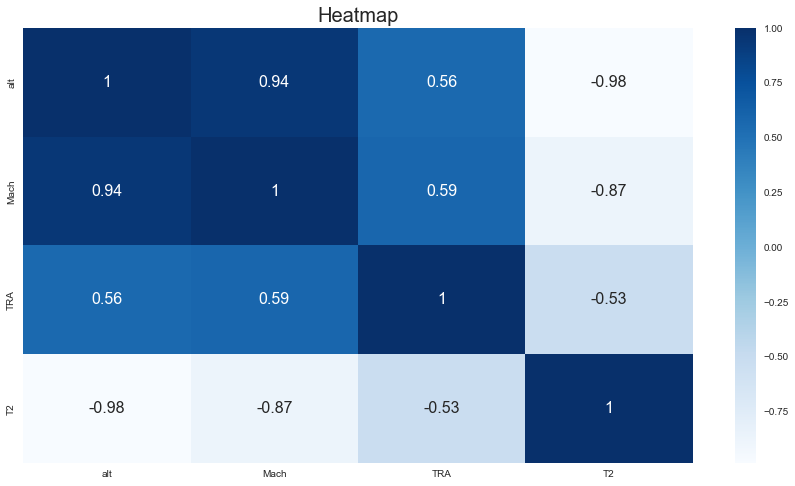

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,620.536686,1500.497778,1918.887446,1305.895297,19.186726,13.769427,19.462331,24.474988,420.022739,426.578936,16.312785,2229.036206,8790.661678,5.117880,1.0,3003.0,0.261135,81.386139,514.889127
1,620.212233,1501.026264,1918.174792,1306.704845,19.168470,13.765780,19.472561,24.482789,419.831067,426.528828,16.314777,2229.338301,8790.557024,5.113072,1.0,3014.0,0.260820,81.386139,514.832078
2,620.691023,1501.435624,1917.553771,1305.988738,19.161991,13.768780,19.459324,24.487983,419.814866,426.332878,16.303461,2227.314527,8793.731801,5.113295,1.0,3023.0,0.262521,81.386139,514.889656
3,620.355416,1500.911321,1917.426968,1305.531529,19.171850,13.754179,19.460298,24.493184,419.747243,426.108069,16.310728,2227.793004,8792.134355,5.112996,1.0,3032.0,0.262836,81.386139,514.874556
4,620.591359,1501.437449,1918.752200,1305.696191,19.161257,13.744312,19.455585,24.458775,419.775992,426.066808,16.285185,2228.217157,8796.438082,5.109202,1.0,3042.0,0.262332,81.386139,514.811204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980008,575.594962,1300.416493,1537.012644,1138.884044,16.588586,13.928236,16.816479,19.332151,251.698566,256.948591,14.448214,1710.470427,8131.187698,2.458707,10.0,3016.0,0.291501,34.277100,516.547136
9980009,576.234568,1299.882098,1537.765798,1139.599918,16.574192,13.918071,16.826887,19.309744,251.809845,257.064075,14.456533,1714.111240,8123.240798,2.462037,10.0,3013.0,0.292068,34.277100,516.589850
9980010,575.367322,1300.168884,1534.960755,1138.679258,16.581624,13.921671,16.832350,19.323433,251.871517,257.033246,14.456594,1710.488984,8132.049740,2.460451,10.0,3010.0,0.291942,34.277100,516.594146
9980011,575.666962,1301.061768,1535.511495,1139.539488,16.571732,13.930149,16.823578,19.315798,251.751500,257.299571,14.464679,1710.823646,8138.051357,2.460564,10.0,3007.0,0.291312,34.277100,516.567693


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06,9.980013e+06
mean,5.665573e+02,1.327675e+03,1.631631e+03,1.117065e+03,1.234625e+01,9.610635e+00,1.253427e+01,1.527752e+01,2.286842e+02,2.327761e+02,9.550281e+00,1.971429e+03,8.231944e+03,2.444046e+00,5.520297e+00,1.723359e+04,5.574720e-01,6.255909e+01,4.862428e+02
std,2.072750e+01,6.674275e+01,1.197157e+02,6.124639e+01,2.831421e+00,2.376510e+00,2.874543e+00,3.373221e+00,5.713897e+01,5.797205e+01,2.711578e+00,1.815930e+02,2.214498e+02,7.501611e-01,2.799720e+00,8.022353e+03,1.192716e-01,1.806220e+01,1.966904e+01
min,4.833501e+02,1.060970e+03,9.167060e+02,6.769659e+02,5.815843e+00,4.372451e+00,5.909529e+00,6.815293e+00,7.776220e+01,7.947957e+01,4.097875e+00,1.467514e+03,7.341465e+03,2.871284e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02
25%,5.520812e+02,1.284405e+03,1.555066e+03,1.075415e+03,9.995506e+00,7.603126e+00,1.014776e+01,1.257936e+01,1.870285e+02,1.904901e+02,7.281582e+00,1.862145e+03,8.090191e+03,1.920730e+00,3.000000e+00,1.055300e+04,4.660110e-01,4.869106e+01,4.703565e+02
50%,5.635053e+02,1.324285e+03,1.640367e+03,1.105070e+03,1.204529e+01,9.301480e+00,1.222877e+01,1.489867e+01,2.144814e+02,2.184626e+02,9.111224e+00,2.023818e+03,8.226402e+03,2.240858e+00,5.000000e+00,1.773300e+04,5.771430e-01,6.881787e+01,4.861761e+02
75%,5.797827e+02,1.365786e+03,1.707043e+03,1.153160e+03,1.455068e+01,1.160344e+01,1.477234e+01,1.769491e+01,2.610826e+02,2.657308e+02,1.162935e+01,2.118918e+03,8.361314e+03,2.821966e+00,8.000000e+00,2.399200e+04,6.517980e-01,7.830999e+01,5.034471e+02
max,6.335294e+02,1.535396e+03,1.978159e+03,1.355420e+03,2.032229e+01,1.570049e+01,2.063133e+01,2.627196e+01,4.534321e+02,4.603692e+02,1.677170e+01,2.293222e+03,8.900753e+03,5.629559e+00,1.000000e+01,3.503300e+04,7.492590e-01,8.876890e+01,5.343834e+02


2.155682911240155e-15 0.9999999999999989
(9980013, 18)


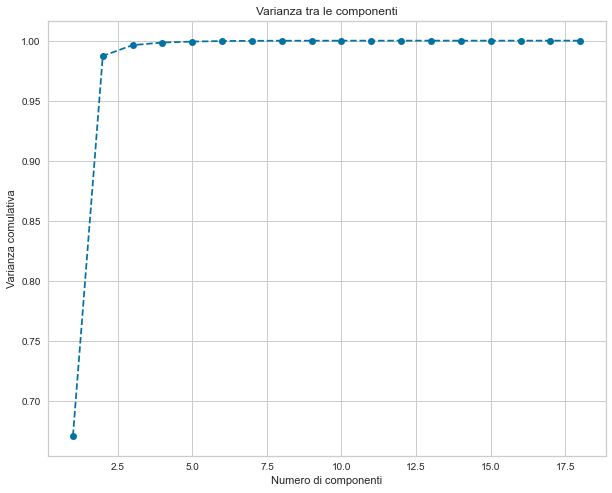

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

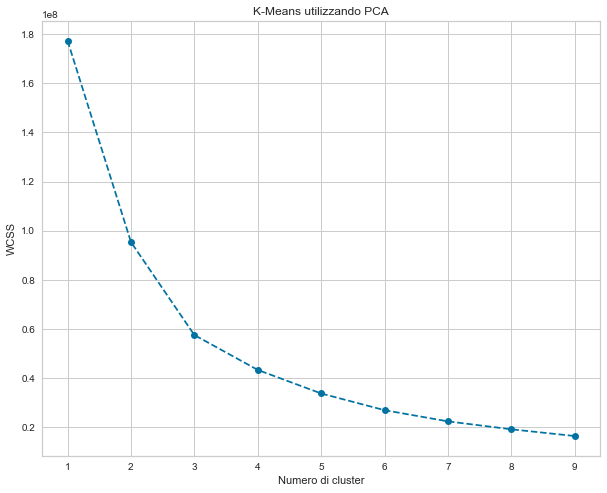

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

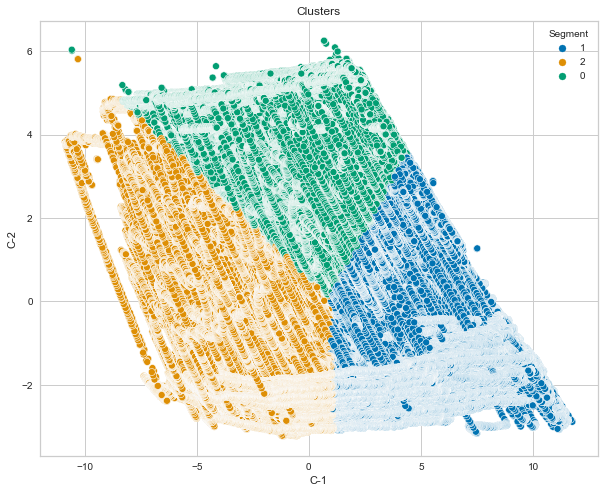

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,620.536686,1500.497778,1918.887446,1305.895297,19.186726,13.769427,19.462331,24.474988,420.022739,426.578936,...,5.117880,1.0,3003.0,0.261135,81.386139,514.889127,10.353222,-1.989036,1,1
1,620.212233,1501.026264,1918.174792,1306.704845,19.168470,13.765780,19.472561,24.482789,419.831067,426.528828,...,5.113072,1.0,3014.0,0.260820,81.386139,514.832078,10.349468,-1.989635,1,1
2,620.691023,1501.435624,1917.553771,1305.988738,19.161991,13.768780,19.459324,24.487983,419.814866,426.332878,...,5.113295,1.0,3023.0,0.262521,81.386139,514.889656,10.349937,-1.993825,1,1
3,620.355416,1500.911321,1917.426968,1305.531529,19.171850,13.754179,19.460298,24.493184,419.747243,426.108069,...,5.112996,1.0,3032.0,0.262836,81.386139,514.874556,10.338400,-1.988611,1,1
4,620.591359,1501.437449,1918.752200,1305.696191,19.161257,13.744312,19.455585,24.458775,419.775992,426.066808,...,5.109202,1.0,3042.0,0.262332,81.386139,514.811204,10.340764,-2.005761,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980008,575.594962,1300.416493,1537.012644,1138.884044,16.588586,13.928236,16.816479,19.332151,251.698566,256.948591,...,2.458707,10.0,3016.0,0.291501,34.277100,516.547136,3.314050,4.210867,0,0
9980009,576.234568,1299.882098,1537.765798,1139.599918,16.574192,13.918071,16.826887,19.309744,251.809845,257.064075,...,2.462037,10.0,3013.0,0.292068,34.277100,516.589850,3.318141,4.205375,0,0
9980010,575.367322,1300.168884,1534.960755,1138.679258,16.581624,13.921671,16.832350,19.323433,251.871517,257.033246,...,2.460451,10.0,3010.0,0.291942,34.277100,516.594146,3.309338,4.217200,0,0
9980011,575.666962,1301.061768,1535.511495,1139.539488,16.571732,13.930149,16.823578,19.315798,251.751500,257.299571,...,2.460564,10.0,3007.0,0.291312,34.277100,516.567693,3.327414,4.201250,0,0


In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [11]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-2.1271983696878598e-15 0.9999999999999993
(2280540, 19)
4.8957976030766065e-15 1.0000000000000004
(2745953, 19)
-1.6691839346915299e-15 0.9999999999999983
(4953520, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,560.021095,1262.620285,1487.189213,1085.488950,13.779055,11.611695,13.988898,16.138431,208.089218,212.445138,11.281586,1703.594685,8007.655436,1.996681,5.510207,10191.786850,0.448454,35.873315,502.354965,0.0
mean,593.298490,1405.883694,1753.205768,1195.450973,15.358127,11.599302,15.592007,19.274628,304.409660,309.577924,12.191730,2083.601115,8487.935877,3.431404,5.487269,10686.752297,0.478102,69.195173,503.007026,1.0
mean,554.742667,1314.271822,1630.735375,1088.149366,10.016991,7.586967,10.169533,12.665395,196.187960,199.561650,7.288939,2032.555450,8193.295525,2.102672,5.543251,24104.743861,0.651661,71.166231,469.531717,2.0


Text(0, 0.5, 'Flight Class # [-]')

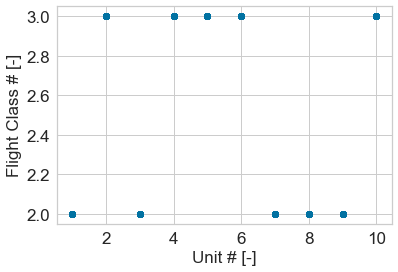

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [13]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 3, 5: 3, 6: 3, 7: 2, 8: 2, 9: 2, 10: 3}

In [14]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,620.536686,1500.497778,1918.887446,1305.895297,19.186726,13.769427,19.462331,24.474988,420.022739,426.578936,...,1.0,3003.0,0.261135,81.386139,514.889127,10.353222,-1.989036,1,1,2
1,620.212233,1501.026264,1918.174792,1306.704845,19.168470,13.765780,19.472561,24.482789,419.831067,426.528828,...,1.0,3014.0,0.260820,81.386139,514.832078,10.349468,-1.989635,1,1,2
2,620.691023,1501.435624,1917.553771,1305.988738,19.161991,13.768780,19.459324,24.487983,419.814866,426.332878,...,1.0,3023.0,0.262521,81.386139,514.889656,10.349937,-1.993825,1,1,2
3,620.355416,1500.911321,1917.426968,1305.531529,19.171850,13.754179,19.460298,24.493184,419.747243,426.108069,...,1.0,3032.0,0.262836,81.386139,514.874556,10.338400,-1.988611,1,1,2
4,620.591359,1501.437449,1918.752200,1305.696191,19.161257,13.744312,19.455585,24.458775,419.775992,426.066808,...,1.0,3042.0,0.262332,81.386139,514.811204,10.340764,-2.005761,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980008,575.594962,1300.416493,1537.012644,1138.884044,16.588586,13.928236,16.816479,19.332151,251.698566,256.948591,...,10.0,3016.0,0.291501,34.277100,516.547136,3.314050,4.210867,0,0,3
9980009,576.234568,1299.882098,1537.765798,1139.599918,16.574192,13.918071,16.826887,19.309744,251.809845,257.064075,...,10.0,3013.0,0.292068,34.277100,516.589850,3.318141,4.205375,0,0,3
9980010,575.367322,1300.168884,1534.960755,1138.679258,16.581624,13.921671,16.832350,19.323433,251.871517,257.033246,...,10.0,3010.0,0.291942,34.277100,516.594146,3.309338,4.217200,0,0,3
9980011,575.666962,1301.061768,1535.511495,1139.539488,16.571732,13.930149,16.823578,19.315798,251.751500,257.299571,...,10.0,3007.0,0.291312,34.277100,516.567693,3.327414,4.201250,0,0,3


In [15]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       2    1154283
1       3    1126257
totale cluster 0 : 2280540
cluster 1
   Classe  Conteggio
0       3    1380081
1       2    1365872
totale cluster 1 : 2745953
cluster 2
   Classe  Conteggio
0       3    3419062
1       2    1534458
totale cluster 2 : 4953520


In [16]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [17]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 3001.0
max: 20245.0


In [18]:
df_segm_pca_kmeans['cycle'] = df_A['cycle'].values
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    if filter_cluster['alt'].min() >= 10000:
        print('Saving Cluster',i)
        filename_out = filename.replace('.h5','')
        filename_out += "_clr_" + str(i) + ".csv"
        df_X_s_u_c_mean = filter_cluster.groupby(['unit', 'cycle']).mean()
        df_X_s_u_c_mean = pd.DataFrame(df_X_s_u_c_mean).reset_index()
        df_X_s_u_c_mean.to_csv("./dataset_csv/"+filename_out,index=False)

Saving Cluster 2
